# Basketball Fantasy League Recommender System

This Jupyter notebook is part of a comprehensive educational project that demonstrates the integration of data engineering and machine learning concepts. The project showcases three key components: API development, ETL (Extract, Transform, Load) processes, and recommender systems. Specifically, we leverage a custom-built BasketballAPI that generates fictional basketball player data and statistics across multiple seasons by simulating the `nba_api` which is an API Client for www.nba.com. This data is then processed through a Python-based ETL pipeline that cleanly transforms and stores the information in a CSV format. 

The project follows the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology, which provides a structured approach through six key phases:
1. **Business Understanding**: Defining the need for a fantasy basketball recommender system
2. **Data Understanding**: Analyzing the BasketballAPI data structure and statistical patterns
3. **Data Preparation**: ETL processes to clean and transform the raw API data
4. **Modeling**: Implementing various recommender system algorithms
5. **Evaluation**: Testing the recommendations' accuracy and relevance
6. **Deployment**: Creating a usable system for fantasy basketball managers

While the project encompasses multiple technical aspects, this notebook primarily focuses on building and evaluating different recommender system techniques to suggest similar players based on their statistical performance and characteristics. This practical approach allows us to explore real-world applications of data science while working with a controlled, yet realistic dataset that simulates five seasons of basketball data across 390 players and multiple teams.

### Import Modules - Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_colwidth', 800)
%matplotlib inline

In [3]:
df = pd.read_csv('basketball_data.csv')

### Exploratory Data Analysis (EDA)

In [4]:
df.columns

Index(['player_id', 'player_name', 'archetype', 'season', 'team',
       'games_played', 'minutes', 'points', 'rebounds', 'assists', 'steals',
       'blocks', 'fg_pct', 'fg3_pct', 'ft_pct'],
      dtype='object')

In [5]:
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,0,Robert Smith,regular,2019-20,SkyBirds,55,36.3,5.4,3.9,NaN,1.2,0.2,0.400,0.302,0.709
1,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
2,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
3,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
4,4,David Hamilton,regular,2019-20,SparkiFY,37,31.9,8.9,6.4,NaN,1.7,0.8,0.433,0.329,NaN


In [6]:
print(f" The dataframe has {df.shape[0]} records and {df.shape[1]} attributes.")

 The dataframe has 1950 records and 15 attributes.


In [7]:
df.dtypes

player_id         int64
player_name      object
archetype        object
season           object
team             object
games_played      int64
minutes         float64
points          float64
rebounds        float64
assists         float64
steals          float64
blocks          float64
fg_pct          float64
fg3_pct         float64
ft_pct          float64
dtype: object

#### <i>Does this dataframe present duplicate values? </i>

In [64]:
print(f"The dataframe should contain {df.player_id.nunique()} unique player")

The dataframe should contain 390 unique player


In [62]:
df.groupby('season')['player_id'].count()

season
2019-20    390
2020-21    390
2021-22    390
2022-23    390
2023-24    390
Name: player_id, dtype: int64

#### <i> Is the relation player-team unique, or do players change team during the course of five seasons? if they do change, what is the ratio?

In [216]:
players_swapped = df.groupby('player_id')['team']\
    .nunique()\
    .reset_index()\
    .rename(columns={'team': 'unique_teams'})
players_swapped_list = players_swapped[players_swapped['unique_teams']>1]\
                                                 ['player_id'].tolist()


In [217]:
print(
    f"Out of {df.player_id.nunique()} players during the 5 seasons analyzed, "
    f"{len(players_swapped_list)} players changed teams, which is a ratio of "
    f"{len(players_swapped_list) / df.player_id.nunique():.2f}."
)


Out of 390 players during the 5 seasons analyzed, 40 players changed teams, which is a ratio of 0.10.


#### <i>Does the dataframe presents any null values?</i>


In [26]:
df.isnull().any()

player_id       False
player_name     False
archetype       False
season          False
team            False
games_played    False
minutes         False
points           True
rebounds         True
assists          True
steals           True
blocks           True
fg_pct           True
fg3_pct          True
ft_pct           True
dtype: bool

In [38]:
print(f" There are {df.isnull().any().sum()} attribues with missing values")

 There are 8 attribues with missing values


In [45]:
#(df.isnull().sum() / df.shape[0])
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  
print(missing_percentage)


points      5.435897
rebounds    5.435897
assists     5.538462
steals      4.358974
blocks      4.205128
fg_pct      3.538462
fg3_pct     5.384615
ft_pct      5.230769
dtype: float64


In [48]:
print(f" On average these fields have {round(missing_percentage.mean(),1)} of missing values")

 On average these fields have 4.9 of missing values


####  <i>This is something to keep into account as we develop our models.Next we to observe the distributions of some attributes. Now let's look at some summary statics.</i>

In [58]:
df.iloc[:,1:].describe()

,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
count,1950.000000,1950.000000,1844.000000,1844.000000,1842.000000,1865.000000,1868.000000,1881.000000,1845.000000,1848.000000
mean,51.735385,25.105949,11.420174,4.495824,3.033659,1.009330,0.641328,0.446874,0.330622,0.752390
std,18.249953,7.595495,5.761876,1.934746,1.938258,0.537009,0.426800,0.048509,0.036472,0.067144
min,20.000000,12.100000,2.000000,1.000000,0.500000,0.000000,0.000000,0.350000,0.250000,0.601000
25%,36.000000,18.400000,7.400000,3.100000,1.700000,0.600000,0.400000,0.413000,0.306000,0.706000
50%,52.000000,25.150000,10.700000,4.200000,2.700000,0.900000,0.500000,0.443000,0.329000,0.748000
75%,68.000000,31.900000,14.400000,5.800000,3.800000,1.300000,0.800000,0.476000,0.354000,0.801000
max,82.000000,38.000000,34.800000,12.000000,11.900000,3.000000,3.000000,0.647000,0.449000,0.947000


#### <i> The attribute games_played appears to have higher variation. It would be helpful to plot the related histogram.</i>

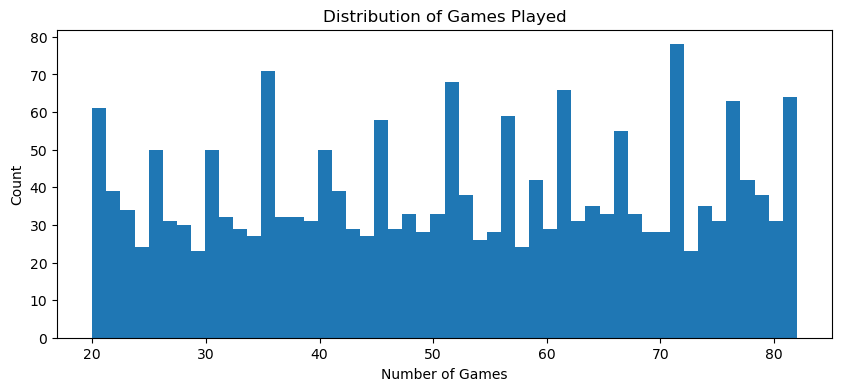

In [52]:
# Create histogram
plt.figure(figsize=(10, 4))
plt.hist(df['games_played'], bins=50)
plt.title('Distribution of Games Played')
plt.xlabel('Number of Games')
plt.ylabel('Count')
plt.show()

#### <i> A box-plot could help identify any outliers. </i>

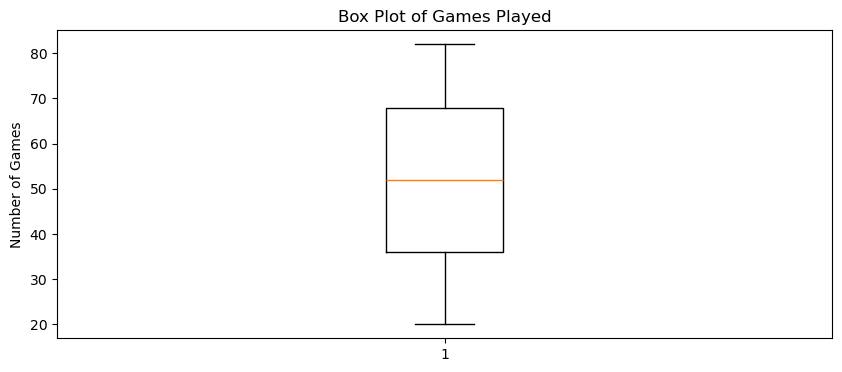

In [65]:
# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(df.games_played)
plt.title('Box Plot of Games Played')
plt.ylabel('Number of Games')
plt.show();

#### <i> The box plot of the games_played attribute doesn't present any outliers </i>

### Rank-Based Recommendations

In this scenario, we are just getting started with a basketball fantasy league and we have no knowledge of players' interactions from previous fantasy leagues except for player and teams data acquired via API. Thus, a rank-based recommender system would focus on sorting players according to specific performance metrics or a composite score. For the purpose of this project, we can prioritize metrics such as points, rebounds, assists, blocks, and steals, assuming a Head to Head league's scoring system.

In [256]:
df.columns

Index(['player_id', 'player_name', 'archetype', 'season', 'team',
       'games_played', 'minutes', 'points', 'rebounds', 'assists', 'steals',
       'blocks', 'fg_pct', 'fg3_pct', 'ft_pct'],
      dtype='object')

In [258]:

from sklearn.preprocessing import MinMaxScaler

def create_rank_based_recommendations(stats_df):
    """
    Create rank-based recommendations using key basketball metrics
    """
    # 1. Select Key Metrics
    key_metrics = [
        'points',
        'rebounds',
        'assists',
        'steals',
        'blocks',
        'fg_pct',
        'fg3_pct',
        'ft_pct'
    ]
    
    # 2. Normalize Metrics
    scaler = MinMaxScaler()
    normalized_stats = pd.DataFrame(
        scaler.fit_transform(stats_df[key_metrics]),
        columns=key_metrics
    )
    
    # 3. Assign Weights to Metrics
    weights = {
        'points': 0.25,
        'rebounds': 0.15,
        'assists': 0.15,
        'steals': 0.125,
        'blocks': 0.125,
        'fg_pct': 0.10,
        'fg3_pct': 0.05,
        'ft_pct': 0.05
    }
    
    # 4. Calculate Composite Score
    composite_scores = pd.Series(0, index=normalized_stats.index)
    for metric, weight in weights.items():
        composite_scores += normalized_stats[metric] * weight
    
    # 5. Create Final Rankings
    rankings = pd.DataFrame({
        'player_id': stats_df['player_id'],
        'composite_score': composite_scores,
        'archetype': stats_df['archetype']
    }).sort_values('composite_score', ascending=False)
    
    return rankings

def get_recommendations(rankings_df, n_recommendations=5, archetype=None):
    """
    Get top N recommendations, optionally filtered by archetype
    """
    if archetype:
        filtered_rankings = rankings_df[rankings_df['archetype'] == archetype]
    else:
        filtered_rankings = rankings_df
        
    return filtered_rankings.head(n_recommendations)

# Example usage:
# Assuming 'stats' is your player statistics DataFrame
stats_df = df  # Convert stats list to DataFrame

# Create rankings
rankings = create_rank_based_recommendations(stats_df)

# Get top 5 overall players
print("Top 5 Overall Players:")
print(get_recommendations(rankings))

# Get top 5 elite scorers
print("\nTop 5 Elite Scorers:")
print(get_recommendations(rankings, archetype='elite_scorer'))

Top 5 Overall Players:
      player_id  composite_score        archetype
1440        270         0.675580     elite_scorer
1064        284         0.650305  elite_playmaker
674         284         0.645443  elite_playmaker
429          39         0.639789     elite_scorer
1110        330         0.635614     elite_scorer

Top 5 Elite Scorers:
      player_id  composite_score     archetype
1440        270         0.675580  elite_scorer
429          39         0.639789  elite_scorer
1110        330         0.635614  elite_scorer
1317        147         0.633785  elite_scorer
1021        241         0.626938  elite_scorer


In [230]:
# Add a 'traded' feature: Check if a player changed teams
#df['traded'] = df.groupby('player_id')['team'].transform('nunique') > 1


In [236]:
# Fill missing values
df.fillna(0, inplace=True)

# Create a player-team interaction matrix
interaction_matrix = df.pivot_table(
    index="player_id", columns="team", values="points", aggfunc="sum", fill_value=0
)

In [244]:
interaction_matrix.head()

team,BIsupremE,HtmlERS,KeyBoardWarriors,LutammS,SkyBirds,SparkiFY,UnitedWeCode,VBADragons
player_id,,,,,,,,
0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,57.2,0.0,0.0
2,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0
3,0.0,35.2,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,7.3,52.2,0.0,0.0


In [237]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [240]:
interaction_matrix.isna().any().sum() 

0

In [249]:
u, s, vt = np.linalg.svd(interaction_matrix,full_matrices=False) 
u.shape, s.shape, vt.shape

((390, 8), (8,), (8, 8))

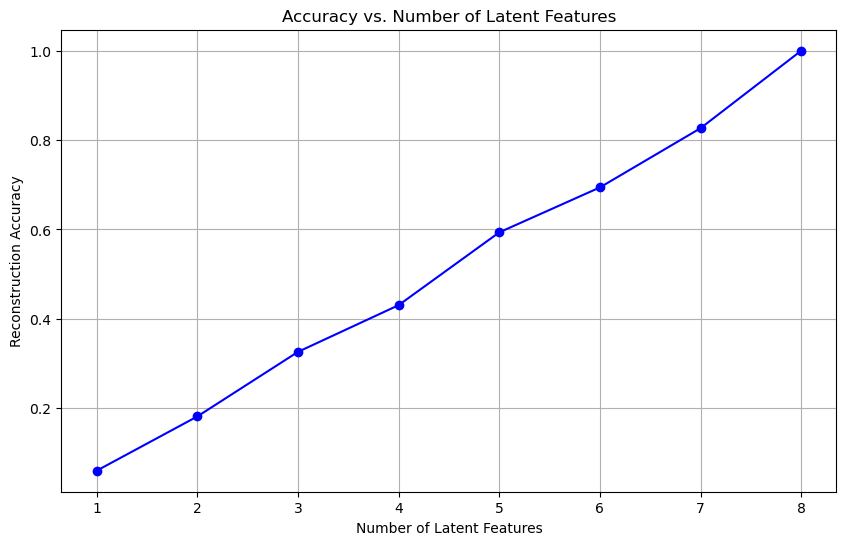


Optimal number of latent features: 8
Maximum accuracy: 1.0000


In [254]:
num_latent_feats = np.arange(1, min(interaction_matrix.shape) + 1)
sum_errs = []
accuracies = []  # Add list to store accuracies

for k in num_latent_feats:
    # Restructure with k latent features
    s_new = np.diag(s[:k])
    u_new = u[:, :k]
    vt_new = vt[:k, :]
    
    # Take dot product
    user_item_est = np.dot(np.dot(u_new, s_new), vt_new)
    
    # Compute error and accuracy
    error = np.sum(np.abs(interaction_matrix - user_item_est))
    total_magnitude = np.sum(np.abs(interaction_matrix))
    accuracy = 1 - (error / total_magnitude)  # Normalize by total magnitude
    
    sum_errs.append(error)
    accuracies.append(accuracy)  # Store accuracy

# Plot accuracies instead of error-based calculation
plt.figure(figsize=(10, 6))
plt.plot(num_latent_feats, accuracies, 'bo-')
plt.xlabel('Number of Latent Features')
plt.ylabel('Reconstruction Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.grid(True)
plt.show()

# Print optimal number of features
optimal_k = num_latent_feats[np.argmax(accuracies)]
print(f"\nOptimal number of latent features: {optimal_k}")
print(f"Maximum accuracy: {max(accuracies):.4f}")

Processed k=5, Accuracy: 0.5933


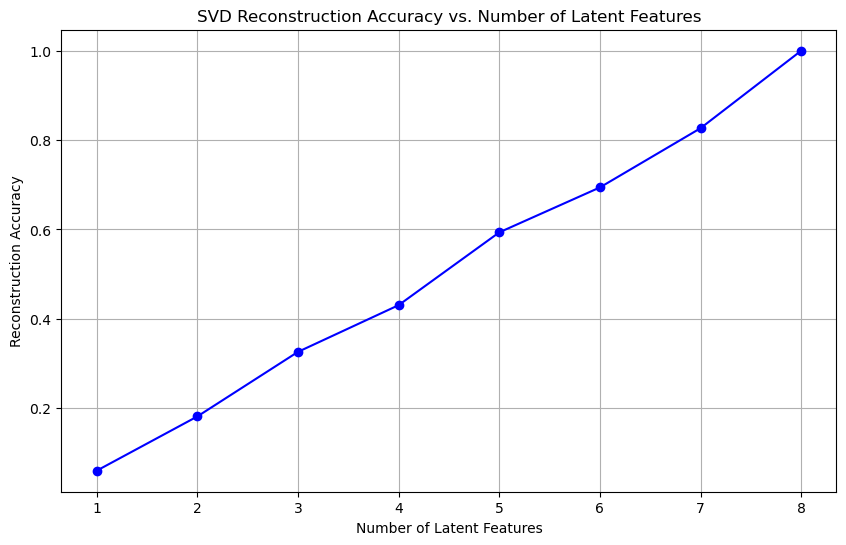


Optimal number of latent features: 8
Maximum accuracy: 1.0000


In [253]:
# 1. First, convert interaction matrix to numpy array for SVD
interaction_matrix = interaction_matrix.to_numpy()

# 2. Perform SVD
u, s, vt = np.linalg.svd(interaction_matrix)

# 3. Define range of latent features to test
#num_latent_feats = np.arange(1, min(interaction_array.shape), 2)
num_latent_feats = np.arange(1, min(interaction_matrix.shape) + 1)

# 4. Initialize lists for storing results
sum_errs = []
accuracies = []

# 5. Create plotting function
def plot_svd_accuracy(num_feats, acc_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(num_feats, acc_scores, 'bo-')
    plt.xlabel('Number of Latent Features')
    plt.ylabel('Reconstruction Accuracy')
    plt.title('SVD Reconstruction Accuracy vs. Number of Latent Features')
    plt.grid(True)
    plt.show()

# 6. Perform SVD analysis
for k in num_latent_feats:
    # Reconstruct matrix with k features
    u_k = u[:, :k]
    s_k = np.diag(s[:k])
    vt_k = vt[:k, :]
    
    # Calculate reconstructed matrix
    reconstructed_array = np.dot(np.dot(u_k, s_k), vt_k)
    
    # Calculate error
    error = np.sum(np.abs(interaction_matrix - reconstructed_array))
    sum_errs.append(error)
    
    # Calculate accuracy
    accuracy = 1 - (error / np.sum(np.abs(interaction_matrix)))
    accuracies.append(accuracy)
    
    # Print progress
    if k % 5 == 0:
        print(f"Processed k={k}, Accuracy: {accuracy:.4f}")

# 7. Plot results
plot_svd_accuracy(num_latent_feats, accuracies)

# 8. Find optimal number of features
optimal_k = num_latent_feats[np.argmax(accuracies)]
print(f"\nOptimal number of latent features: {optimal_k}")
print(f"Maximum accuracy: {max(accuracies):.4f}")

/opt/anaconda3/envs/DataScience/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


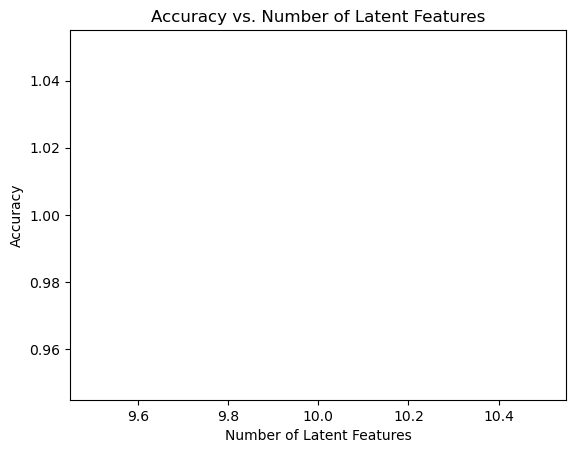

In [242]:


# Perform SVD
u, s, vt = np.linalg.svd(interaction_matrix, full_matrices=False)

# Define number of latent features to test
num_latent_feats = np.arange(10, min(interaction_matrix.shape) + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new = np.diag(s[:k])  # Create diagonal matrix for top k singular values
    u_new = u[:, :k]        # Keep first k columns of u
    vt_new = vt[:k, :]      # Keep first k rows of vt

    # Take dot product to reconstruct the matrix
    user_item_est = np.dot(np.dot(u_new, s_new), vt_new)

    # Compute error for each prediction compared to actual value
    diffs = np.subtract(interaction_matrix, user_item_est)

    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

# Plot the accuracy vs number of latent features
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / interaction_matrix.size)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


In [238]:
# Apply SVD for matrix factorization
svd = TruncatedSVD(n_components=15, random_state=42)
latent_features = svd.fit_transform(interaction_matrix)

# Reconstruct the matrix using latent features
predicted_matrix = np.dot(latent_features, svd.components_)
predicted_df = pd.DataFrame(
    predicted_matrix, index=interaction_matrix.index, columns=interaction_matrix.columns
)

# Normalize the predicted scores for easier interpretation
scaler = MinMaxScaler()
predicted_df_normalized = pd.DataFrame(
    scaler.fit_transform(predicted_df), 
    index=predicted_df.index, 
    columns=predicted_df.columns
)


ValueError: n_components(15) must be <= n_features(8).

In [202]:
top3_blocker_teams = df.groupby('team')['blocks'].mean()\
                     .reset_index()\
                     .sort_values('blocks',ascending=False).head(3)
top3_blocker_teams

,team,blocks
6,UnitedWeCode,0.706393
7,VBADragons,0.648162
1,HtmlERS,0.648018


In [184]:
players_swapped = df.groupby('player_id')['team']\
    .nunique()\
    .reset_index()\
    .rename(columns={'team': 'unique_teams'})
players_swapped = players_swapped[players_swapped['unique_teams']>1]\
                                                 ['player_id'].tolist()


In [187]:
df[df['player_id'].isin(players_swapped)].iloc[:,5:].describe()

,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
count,200.000000,200.000000,191.000000,192.000000,188.000000,186.000000,196.000000,188.000000,191.000000,183.000000
mean,50.530000,25.962500,11.654450,4.581250,2.973936,0.991935,0.610204,0.445622,0.333236,0.753995
std,18.437702,7.438967,6.038401,1.837384,1.646455,0.512007,0.364443,0.051456,0.039093,0.067611
min,20.000000,12.200000,2.000000,1.100000,0.600000,0.000000,0.000000,0.351000,0.251000,0.603000
25%,34.750000,19.675000,7.450000,3.275000,1.700000,0.600000,0.400000,0.413000,0.308000,0.708500
50%,49.000000,26.150000,10.800000,4.250000,2.700000,0.900000,0.500000,0.442500,0.331000,0.751000
75%,68.000000,32.525000,14.550000,6.125000,3.925000,1.300000,0.800000,0.474000,0.354500,0.799500
max,80.000000,38.000000,34.200000,11.000000,11.100000,2.700000,2.800000,0.646000,0.442000,0.946000


In [ ]:
# Apply SVD for matrix factorization
svd = TruncatedSVD(n_components=15, random_state=42)
latent_features = svd.fit_transform(interaction_matrix)

# Reconstruct the matrix using latent features
predicted_matrix = np.dot(latent_features, svd.components_)
predicted_df = pd.DataFrame(
    predicted_matrix, index=interaction_matrix.index, columns=interaction_matrix.columns
)

# Normalize the predicted scores for easier interpretation
scaler = MinMaxScaler()
predicted_df_normalized = pd.DataFrame(
    scaler.fit_transform(predicted_df), 
    index=predicted_df.index, 
    columns=predicted_df.columns
)


In [178]:
df[df['player_id']==25]['team']

25             BIsupremE
415     KeyBoardWarriors
805     KeyBoardWarriors
1195    KeyBoardWarriors
1585           BIsupremE
Name: team, dtype: object

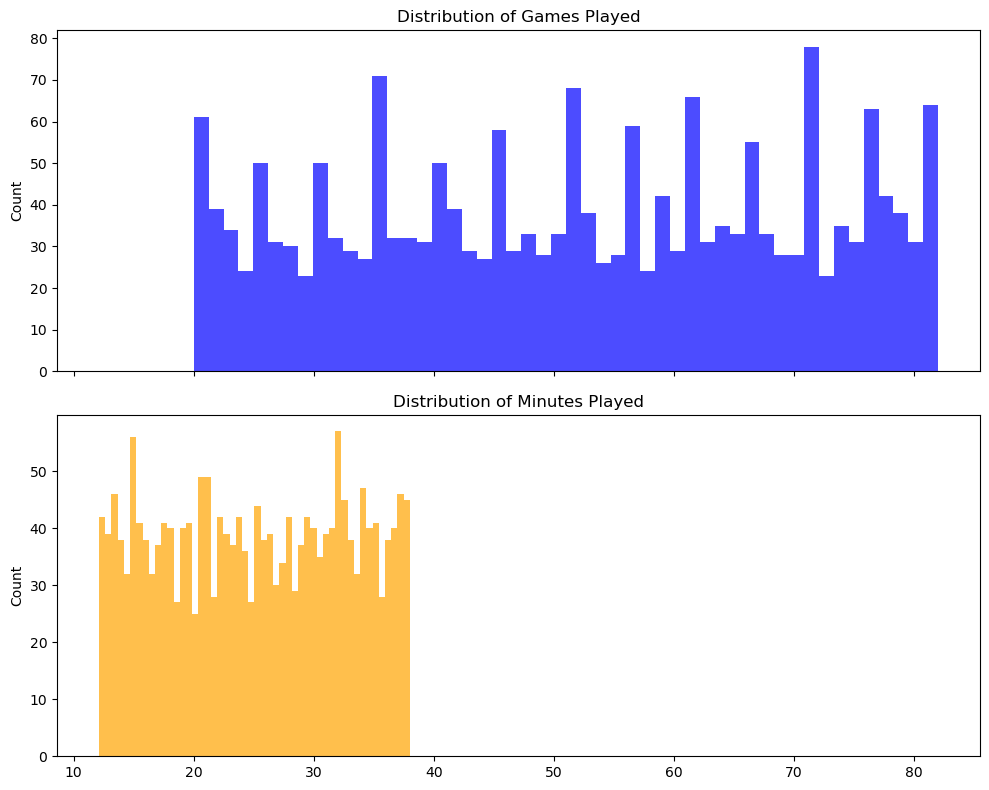

In [56]:
# Create subplots: one stacked on top of the other
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top histogram
axes[0].hist(df['games_played'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of Games Played')
axes[0].set_ylabel('Count')

# Bottom histogram (optional customization to show some variation)
axes[1].hist(df['minutes'], bins=50, color='orange', alpha=0.7)
axes[1].set_title('Distribution of Minutes Played')
#axes[1].set_xlabel('Number of Minutes Played')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
# Add a 'traded' feature: Check if a player changed teams
df['traded'] = df.groupby('player_id')['team'].transform('nunique') > 1

In [6]:
from FantasyRecommenderClass import FantasyRecommender

# Example usage:
recommender = FantasyRecommender()
stats_df = df  # Your stats DataFrame

# Create initial rankings
rankings = recommender.create_rank_based_recommendations(stats_df)

# Get top 5 available players
print("Top 5 Available Players:")
recommendations = recommender.get_recommendations(rankings)
print(recommendations[['player_name', 'composite_score', 'traded']])

# Select a player
player_id = recommendations.iloc[0]['player_id']
recommender.select_player(player_id)

# Get new recommendations (will exclude selected player)
print("\nNew Top 5 Available Players:")
new_recommendations = recommender.get_recommendations(rankings)
print(new_recommendations[['player_name', 'composite_score', 'traded']])

Top 5 Available Players:
         player_name  composite_score  traded
1440  Richard Morris         0.626077   False
1317  Kristen Murphy         0.612403   False
429       James Mack         0.607516   False
1110    Theresa Cook         0.596710   False
1021     Todd Garcia         0.595573    True

New Top 5 Available Players:
         player_name  composite_score  traded
1317  Kristen Murphy         0.612403   False
429       James Mack         0.607516   False
1110    Theresa Cook         0.596710   False
1021     Todd Garcia         0.595573    True
1064      Diana Cain         0.594753   False
